In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import warnings

import helpers as hlp
import helpers.features as feat
import helpers.dataset.PlantVillage as pv
import helpers.split as split
import helpers.visual_words as vw

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# enlever FutureWarning de sklearn 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")


#
# train/test sets
# 
train, test = split.load(configs.split)
print("Train size", len(train))
print("Test size", len(test))
print()


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)
print()

Train size 3711
Test size 928

Dataset (60343, 4)



In [3]:
#
# features orb
#

configs.orb.force_generate = True
configs.orb.read_only = False

if "orb_features" in locals():
    del orb_features

with hlp.Profile() as orb_loading:
    #
    # obtenir les orb features pour chaque image du dataset
    #
    orb_iter = feat.DatasetIter(pv_dataset, 
                                pv_dataframe.loc[train + test, "image_path"].items(),
                                len(train + test)) #pv_dataframe.shape[0])
    orb_features = feat.load(configs.orb, orb_iter)

print(f"ORB loading:", orb_loading.round_duration(), "s")
print("ORB features", orb_features.features.shape)
print("ORB keypoints", orb_features.key_points.shape)
print()

if configs.orb.force_generate or orb_features.train_features is None:
    feat.update_train_test(orb_features, train, test)

print("ORB features", orb_features.features.shape)
print("ORB train features", orb_features.train_features.shape)
print("ORB test features", orb_features.test_features.shape)
print()

Extraire features


  0%|          | 0/4639 [00:00<?, ?it/s]

ORB loading: 26.4 s
ORB features (1460929, 128)
ORB keypoints (1460929, 7)

ORB features (1460929, 128)
ORB train features (1167882, 128)
ORB test features (293047, 128)



In [4]:
#
# bovw orb
#

configs.orb_bovw.force_generate = True # True

if "orb_bovw" in locals():
    del orb_bovw

# soyez patient, ce n'est pas interactif
with hlp.Profile() as orb_bovw_profile:
    orb_bovw = vw.load_bovw(configs.orb_bovw, orb_features.train_features)

print("ORB BoVW loading:", orb_bovw_profile.round_duration(), "s")
print("ORB BoVW clusters:", orb_bovw.model.cluster_centers_.shape)

Construction Bag of Visual Words
ORB BoVW loading: 3.92 s
ORB BoVW clusters: (150, 128)


In [5]:
#
# dataset vw orb
#

configs.orb_dataset_vw.force_generate = True

if "orb_pv_vw" in locals():
    del orb_pv_vw

with hlp.Profile() as orb_pv_vw_loading:
    orb_pv_vw = vw.load_dataset_vw(configs.orb_dataset_vw,
                                   orb_features,
                                   configs.orb_bovw,
                                   orb_bovw,
                                   train,
                                   test)
    
print(f"ORB PlantVillage Visual Word loading:", orb_pv_vw_loading.round_duration(), "s")
print("ORB PlantVillage Visual Words", orb_pv_vw.vw_freqs.shape)

Construction Visual Words


  0%|          | 0/4639 [00:00<?, ?it/s]

ORB PlantVillage Visual Word loading: 10.58 s
ORB PlantVillage Visual Words (4639, 150)


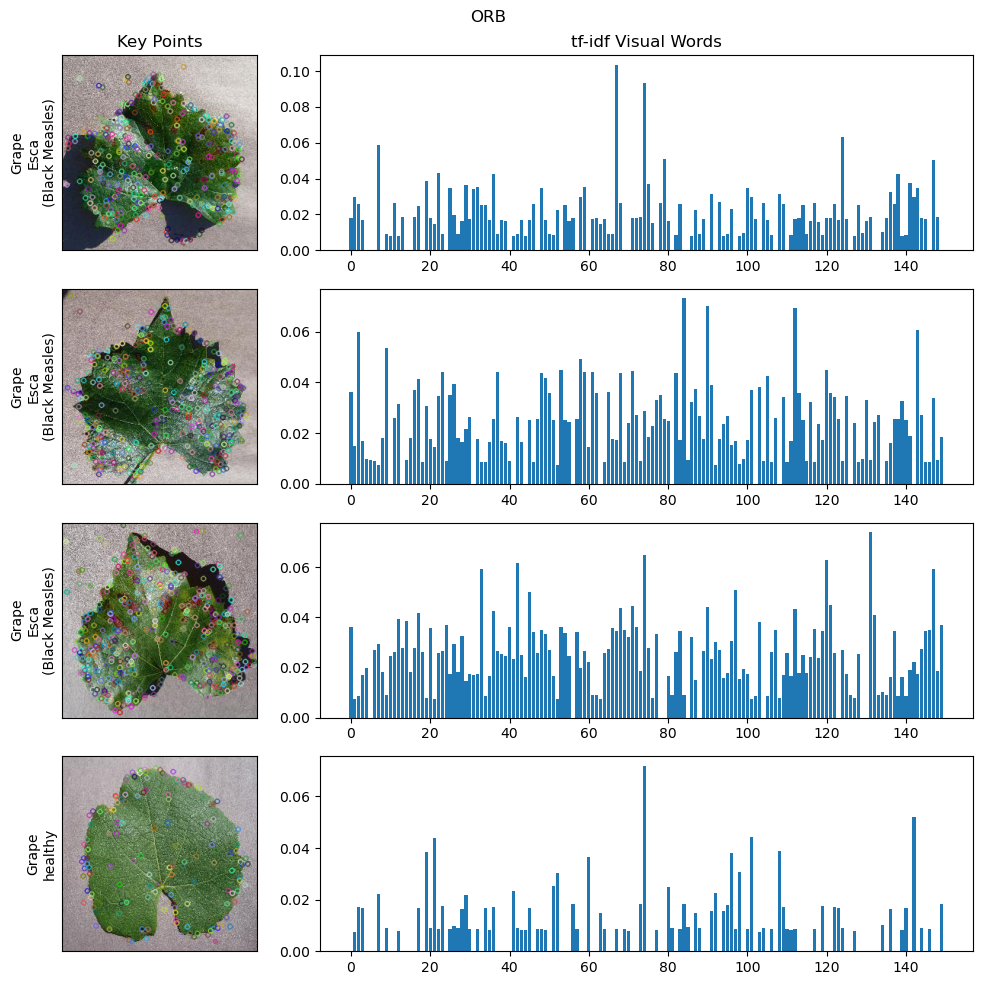

In [6]:
#
# visualiser quelques visual words orb
#

SAMPLES_GRID = (4, 2)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def affiche_image(image_indices, visual_words, idf, features, pv_vw):
    x_range = range(visual_words.n_clusters)
    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE,
                                width_ratios=[1, 3])

    for i, image_index in enumerate(image_indices):
        key_points = features.index_to_key_points[str(image_index)][...]
        visual_words_freq = pv_vw.index_to_vw_freqs[str(image_index)][...].flatten()
        tf_idf = np.multiply(idf, visual_words_freq)

        image = pv_dataset.get_image(image_index)
        image_key_points = visual_words.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[i, 0])
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points)

        plt.sca(axes[i, 1])
        plt.bar(x_range, tf_idf)

    axes[0, 0].set_title("Key Points")
    axes[0, 1].set_title("tf-idf Visual Words")
    

# selectionner quelques images aleatoirement
random.seed(33)
image_indices = random.choices(train, k=SAMPLES_COUNT)
image_indices.sort()

affiche_image(image_indices,
              vw.VisualWords(configs.orb, orb_bovw.model),
              np.ravel(orb_bovw.idf),
              orb_features, 
              orb_pv_vw)

plt.suptitle("ORB")
plt.tight_layout()
plt.show() 

In [7]:
def load_knn(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5
        
        pipe = Pipeline([("scaler", StandardScaler()),
                         ("knn", KNeighborsClassifier())])

        pipe_parameters = {"knn__n_neighbors": range(1, 5)}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_knn(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "KNN n_neighbors:", pipe.named_steps["knn"].n_neighbors)
    print(method_name, "KNN test score:", accuracy_score(test_y, test_y_hat).round(4))
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - KNN - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()


#
# mettre le data dans une forme acceptable pour sklearn
#
train_y = pv_dataframe.loc[train, "label"]
test_y = pv_dataframe.loc[test, "label"]

# *_pv_vw garantissent l'ordre donne par train/test lors de l'etape precedante 
# alors faire gaffe a ne pas le changer
orb_train_x = np.multiply(orb_pv_vw.train_vw_freqs[...], orb_bovw.idf)
orb_test_x = np.multiply(orb_pv_vw.test_vw_freqs[...], orb_bovw.idf)

assert orb_train_x.shape[0] == train_y.shape[0]
assert orb_test_x.shape[0] == test_y.shape[0]

print("ORB PlantVillage train Visual Words", orb_train_x.shape)
print("ORB PlantVillage test Visual Words", orb_train_x.shape)

ORB PlantVillage train Visual Words (3711, 150)
ORB PlantVillage test Visual Words (3711, 150)


In [8]:
def load_rf(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5

        pipe = Pipeline([("scaler", StandardScaler()),
                         ("forest_gump", RandomForestClassifier())])

        pipe_parameters = {"forest_gump__n_estimators": range(150, 200)}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS,
                                  n_jobs=-1)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_rf(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "Random Forest n_estimators:", pipe.named_steps["forest_gump"].n_estimators)
    print(method_name, "Random Forest test score:", accuracy_score(test_y, test_y_hat).round(4))
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - Random Forest - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()
    

Search time: 1.3 s
Best params {'knn__n_neighbors': 3}
Train score: 0.7774

ORB KNN n_neighbors: 3
ORB KNN test score: 0.7931
Effectifs test set:
Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


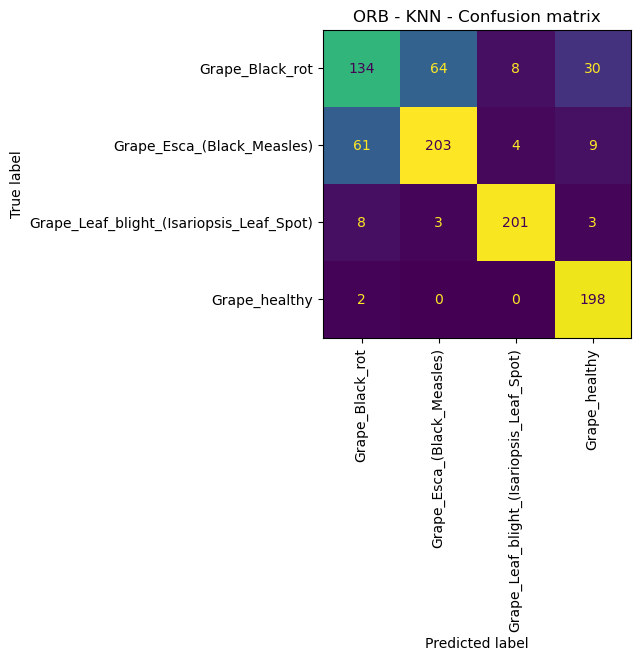

In [9]:
#
# ORB KNN
#
orb_knn_pipe = load_knn("models/orb_knn.pkl", orb_train_x, train_y)
analysis_knn("ORB", orb_knn_pipe, orb_test_x, test_y)

Search time: 68.07 s
Best params {'forest_gump__n_estimators': 191}
Train score: 0.8345

ORB Random Forest n_estimators: 191
ORB Random Forest test score: 0.8319
Effectifs test set:
Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


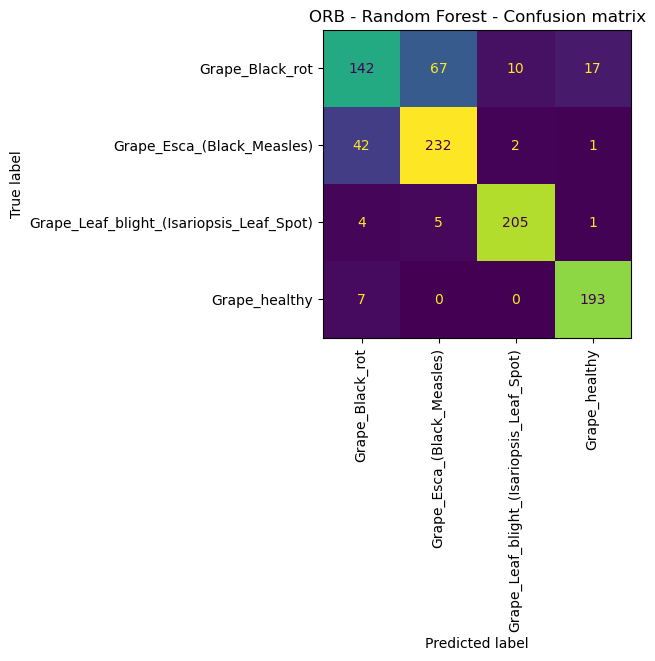

In [10]:
#
# ORB Random Forest
#
orb_rf_pipe = load_rf("models/orb_random_forest.pkl", orb_train_x, train_y)
analysis_rf("ORB", orb_rf_pipe, orb_test_x, test_y)